# Drugi domaci zadatak - softmax klasifikator

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def train_test_split(x, y, size_train=0.8, random_state=0):
    rng = np.random.RandomState(random_state)
    zzz = rng.permutation(x.shape[0])

    n_train = int(size_train * x.shape[0])
    train_ind = zzz[:n_train]
    test_ind = zzz[n_train:]

    x_train = x.iloc[train_ind]
    y_train = y.iloc[train_ind]

    x_test = x.iloc[test_ind]
    y_test = y.iloc[test_ind]
    
    return x_train, y_train, x_test, y_test

In [3]:
def stand(x_train, x_test):
    sr_vr = x_train.mean()
    std = x_train.std(ddof=0)

    x_train_std = (x_train - sr_vr) / std
    x_test_std = (x_test - sr_vr) / std
    
    return x_train_std, x_test_std

In [4]:
def make_X(x):
    X = np.asarray(x)
    ones = np.ones((X.shape[0], 1))
    X = np.hstack([ones, X])
    return X

In [5]:
class MultinomialLogisticRegression:
    def __init__(self):
        pass
    
    def probability(self, theta, X):
        logit = theta @ X.T
        logit = np.vstack([logit, np.zeros((1, logit.shape[1]))])
        logit = logit - np.max(logit, axis=0)
        exp_logit = np.exp(logit)
        P = exp_logit / np.sum(exp_logit, axis=0)
        return P
    
    def predict(self, theta, X):
        P = self.probability(theta, X)
        return np.argmax(P, axis=0)
    
    def accuraccy(self, X, y, theta):
        return np.mean(self.predict(theta, X) == y)
    
    def cross_entrophy(self, P, y):
        eps = 1e-12
        y = np.asanyarray(y)
        m = y.shape[0]
        return -np.mean(np.log(P[y, np.arange(m)] + eps))
    
    def grad(self, X, y, P):
        m = X.shape[0]
        y = np.asarray(y)
        y0 = (y == 0)
        y1 = (y == 1)
        d_l0 = (P[0, :] - y0) @ X
        d_l1 = (P[1, :] - y1) @ X
        return np.vstack([d_l0, d_l1]) / m
    
    def train(self, x_train, y_train, x_val, y_val, alpha=0.1, batch_size=16, epochs=100, ranodm_state=0):
        m = x_train.shape[0]
        rng = np.random.RandomState(ranodm_state)
        theta = 0.01 * rng.standard_normal((2, x_train.shape[1]))
        
        metrics = {'train_loss': [], 'val_acc': [], 'epoch_time': [], 'alpha': alpha, 'batch_size': batch_size}
        
        for _ in range(epochs):
            t0 = time.time()
            ind = np.arange(m)
            rng.shuffle(ind)
            x_ep = x_train[ind]
            y_ep = y_train[ind]
            for i in range(0, m, batch_size):
                x_b = x_ep[i:i+batch_size]
                y_b = y_ep[i:i+batch_size]
                P = self.probability(theta, x_b)
                delta_theta = self.grad(x_b, y_b, P)
                theta = theta - alpha * delta_theta
                
            P_tr = self.probability(theta, x_train)
            tr_loss = self.cross_entrophy(P_tr, y_train)
            val_acc = self.accuraccy(x_val, y_val, theta)
            metrics['train_loss'].append(tr_loss)
            metrics['val_acc'].append(val_acc)
            metrics['epoch_time'].append(time.time() - t0)
                   
        return metrics, theta
    
    def estimate_convergence_epoch(self, values, tol=0.001):
        values = np.asarray(values)
        final = values[-1]
        hit = np.where(np.abs(values - final) <= tol)[0]
        return int(hit[0] + 1) if len(hit) else len(values)

In [6]:
data = pd.read_csv('multiclass_data.csv', header=None)

x = data.iloc[:, :-1]
y = data.iloc[:, -1]

x_train, y_train, x_test, y_test = train_test_split(x, y)
x_train_std, x_test_std = stand(x_train, x_test)

X_train = make_X(x_train_std)
X_test = make_X(x_test_std)

y_train = np.asarray(y_train, dtype=int)
y_test = np.asarray(y_test, dtype=int)

In [7]:
model = MultinomialLogisticRegression()

alphas  = [0.001, 0.1, 1, 10]
batches = [1, 128, 1024]
epochs = 150

results = {}

for a in alphas:
    for bs in batches:
        metrics, theta = model.train(
            X_train, y_train, X_test, y_test,
            alpha=a, batch_size=bs, epochs=epochs, ranodm_state=0
        )
        results[(a, bs)] = (metrics, theta)

In [8]:
rows = []
for (a, bs), (m, _) in results.items():
    final_acc = m['val_acc'][-1]
    avg_ep_t = np.mean(m['epoch_time'])
    conv_ep = model.estimate_convergence_epoch(m['train_loss'])
    time_to_conv = avg_ep_t * conv_ep
    rows.append((a, bs, final_acc, conv_ep, avg_ep_t, time_to_conv))
    print(f'alpha: {a}, bs: {bs}, ep: {conv_ep}')

rows = sorted(rows, key=lambda t: (t[2], -t[5]), reverse=True)
best = rows[0]
best_alpha, best_bs = best[0], best[1]

alpha: 0.001, bs: 1, ep: 105
alpha: 0.001, bs: 128, ep: 149
alpha: 0.001, bs: 1024, ep: 148
alpha: 0.1, bs: 1, ep: 150
alpha: 0.1, bs: 128, ep: 118
alpha: 0.1, bs: 1024, ep: 147
alpha: 1, bs: 1, ep: 150
alpha: 1, bs: 128, ep: 13
alpha: 1, bs: 1024, ep: 74
alpha: 10, bs: 1, ep: 150
alpha: 10, bs: 128, ep: 30
alpha: 10, bs: 1024, ep: 5


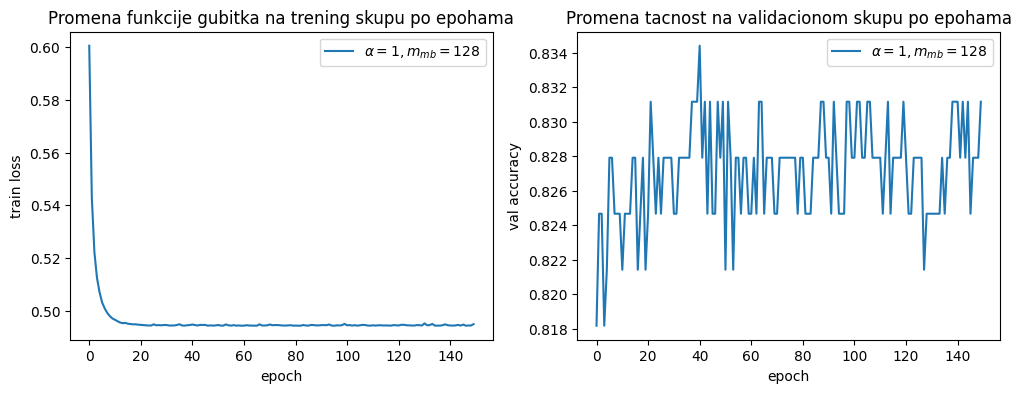

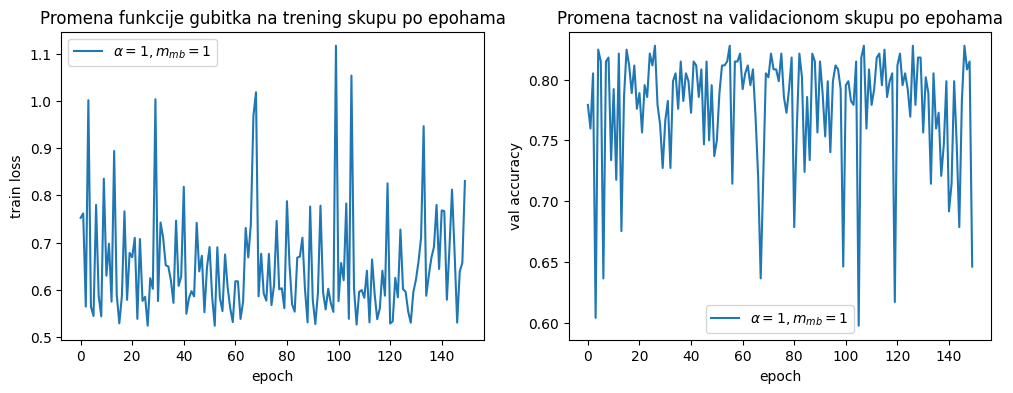

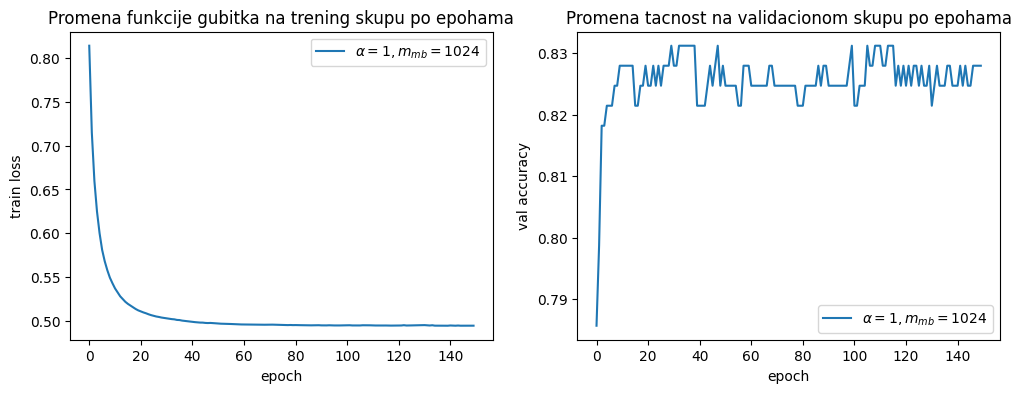

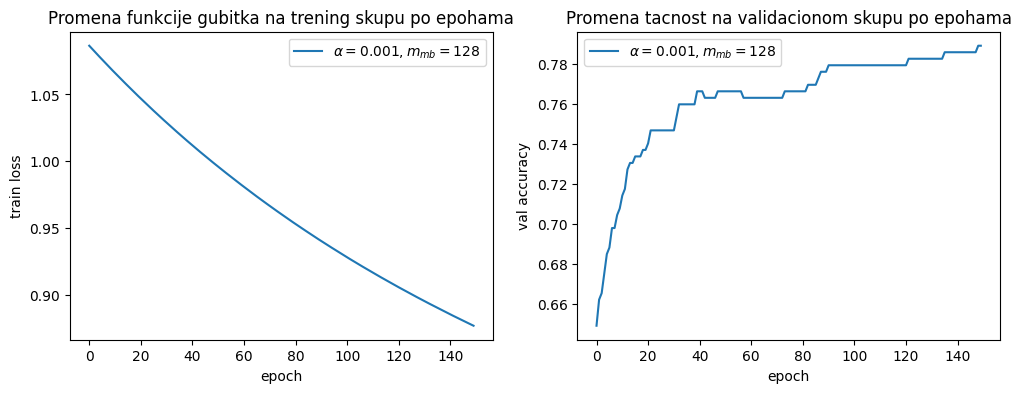

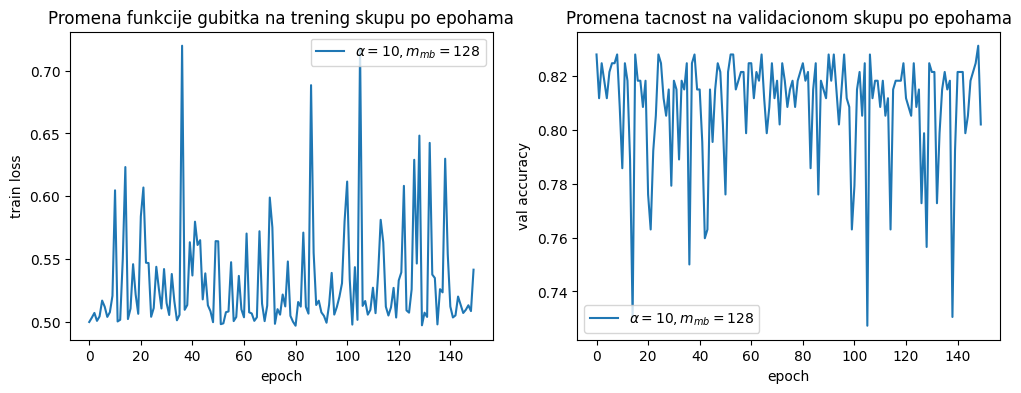

In [9]:
combo_list = [
    (best_alpha, best_bs),
    (best_alpha, batches[0]),
    (best_alpha, batches[-1]),
    (alphas[0], best_bs),
    (alphas[-1], best_bs),
]

for a, bs in combo_list:
    m, _ = results[(a, bs)]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.plot(m['train_loss'], label=rf'$\alpha={a}, m_{{mb}}={bs}$')
    plt.xlabel('epoch')
    plt.ylabel('train loss')
    plt.legend()
    plt.title('Promena funkcije gubitka na trening skupu po epohama')
    
    plt.subplot(122)
    plt.plot(m['val_acc'], label=rf'$\alpha={a}, m_{{mb}}={bs}$')
    plt.xlabel('epoch')
    plt.ylabel('val accuracy')
    plt.legend()
    plt.title('Promena tacnost na validacionom skupu po epohama')
    
    plt.show()

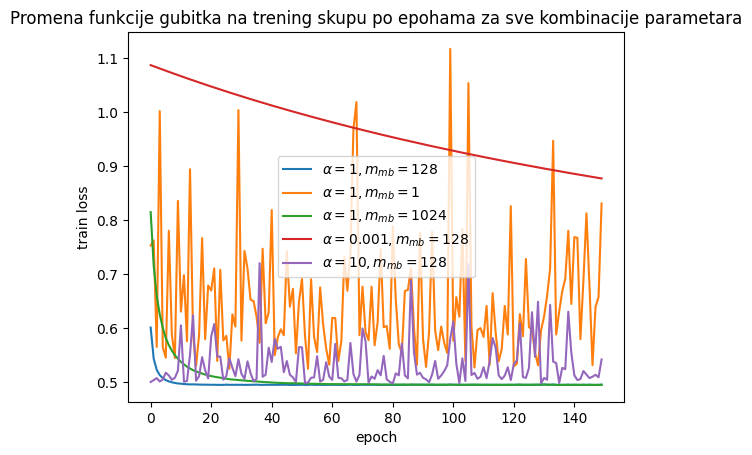

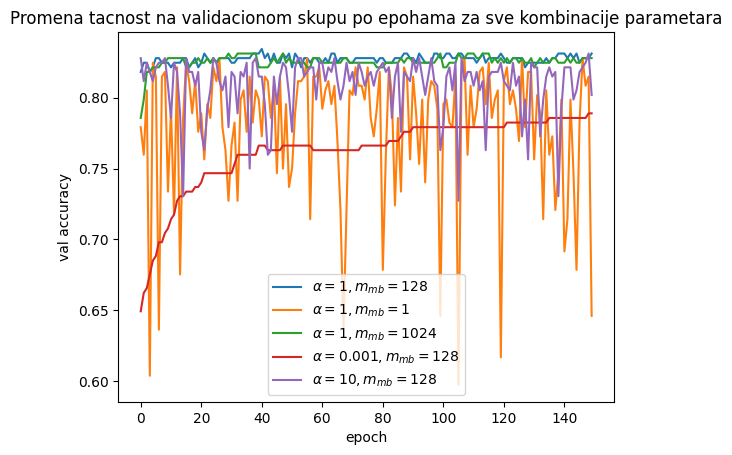

In [10]:
plt.figure()
for a, bs in combo_list:
    m, _ = results[(a, bs)]
    plt.plot(m['train_loss'], label=rf'$\alpha={a}, m_{{mb}}={bs}$')
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.title('Promena funkcije gubitka na trening skupu po epohama za sve kombinacije parametara')
plt.show()

plt.figure()
for a, bs in combo_list:
    m, _ = results[(a, bs)]
    plt.plot(m['val_acc'], label=rf'$\alpha={a}, m_{{mb}}={bs}$')
plt.xlabel('epoch')
plt.ylabel('val accuracy')
plt.legend()
plt.title('Promena tacnost na validacionom skupu po epohama za sve kombinacije parametara')
plt.show()

In [11]:
avg_epoch_time = pd.DataFrame(index=alphas, columns=batches, dtype=float)
time_to_conv = pd.DataFrame(index=alphas, columns=batches, dtype=float)

for a in alphas:
    for bs in batches:
        m, _ = results[(a, bs)]
        avg_t = float(np.mean(m['epoch_time']))
        conv_ep = model.estimate_convergence_epoch(m['val_acc'])
        avg_epoch_time.loc[a, bs] = avg_t
        time_to_conv.loc[a, bs]   = avg_t * conv_ep

In [12]:
print('Prosecno trajanje epohe')
avg_epoch_time

Prosecno trajanje epohe


,1,128,1024
0.001,0.016475,0.000286,0.000169
0.100,0.017022,0.000283,0.000169
1.000,0.016579,0.000284,0.000168
10.000,0.016528,0.000288,0.000173


In [13]:
print('Ukupno vreme do konvergencije')
time_to_conv

Ukupno vreme do konvergencije


,1,128,1024
0.001,0.197695,0.042550,0.018209
0.100,0.817041,0.004524,0.018115
1.000,1.657917,0.006237,0.001684
10.000,2.479267,0.014397,0.000345


Za neke kombinacije parametara $(\alpha, m_{mb})$ algoritam ne konvergira, ali su u tabeli prikazana sva vremena. To se desava za kombinaciju parametara: $(0.001, 128), (0.001, 1024), (1, 1), (10, 1), (10, 128)$ sto je zakljuceno na osnovu grafika.

In [14]:
best_metrics, best_theta = results[(best_alpha, best_bs)]
test_acc = model.accuraccy(X_test, y_test, best_theta)
print(f'Tacnost modela sa optimalnim parametrima alpha = {best_alpha} i m_mb = {best_bs} je {100*test_acc:.1f}%')

Tacnost modela sa optimalnim parametrima alpha = 1 i m_mb = 128 je 83.1%
